In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [27]:
# Load pre-processed data
Gold_CRC_GE = pd.read_csv("SingaporeCRC_data/MSIde_exp.csv", index_col=0, delimiter=",")
Gold_CRC_GE = Gold_CRC_GE.T

pid = Gold_CRC_GE.index #.astype('float')
Gold_CRC_GE.insert(0,'patient_id',pid)

Gold_CRC_GE

,patient_id,TAC1,SLC13A2,HOXC8,CCDC85A,MSH4,F7,DLX3,MS4A12,RBFOX1,...,PWRN3,CKBP1,LINC01195,UBE2FP2,LINC01177,KRT23,CRAT40,MIR4686,MIR5692C1,RPL23AP77
X1504,X1504,0.150865,0.031442,0.014380,0.117586,0.138560,0.625151,0.416349,0.056656,0.782366,...,2.838393,0.000000,0.682927,0.179771,0.597685,4.591044,1.939303,2.215627,1.411125,0.145117
X1603,X1603,0.911631,0.487500,0.000000,0.122059,0.119816,0.733709,0.016125,1.890287,0.060361,...,0.000000,0.000000,0.307336,0.106024,0.112975,2.776638,0.376516,2.195063,2.820293,0.000000
X1324,X1324,0.066874,1.233493,0.004499,0.036924,0.116298,0.199512,0.039120,0.069026,0.045128,...,0.340978,0.000000,0.237493,0.048902,0.186388,3.292372,1.349458,2.244069,2.372126,0.000000
X834,X834,0.155618,0.398642,0.000000,0.014148,0.071768,0.951181,0.270268,0.282309,0.039839,...,0.017316,0.012916,0.190823,0.000000,0.092336,2.180405,3.597639,1.770618,1.063797,0.038719
X47,X47,0.594452,0.115947,0.038960,0.037877,0.529422,0.018677,0.086426,0.117315,0.139223,...,0.045355,0.011381,0.000000,1.920003,0.000000,0.075379,0.079571,0.000000,0.000000,0.034402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1607,X1607,0.241303,1.934167,0.028354,0.023844,0.264366,0.233425,0.027388,0.590600,0.073154,...,0.000000,0.000000,0.000000,0.061165,0.049218,3.299821,0.859288,1.550284,0.000000,0.119461
X1448,X1448,0.065199,0.558250,0.287339,0.083389,0.241614,0.772533,0.109036,0.994777,0.169361,...,0.583674,0.040260,0.000000,0.000000,0.148300,3.956319,2.734521,2.253486,4.152947,0.063782
X891,X891,0.000000,0.005031,0.012878,0.053363,0.078074,0.727017,0.016893,0.047841,0.048284,...,0.233381,0.000000,0.034051,0.524145,0.000000,2.064755,5.271607,1.970973,0.000000,0.187379
X858,X858,0.000000,0.005289,0.761545,0.067219,1.260629,0.049620,0.016077,0.194538,0.002780,...,0.000000,0.000000,0.000000,0.973396,0.000000,0.030768,0.000000,0.636250,0.000000,0.000000


In [28]:
metadata = pd.read_csv("SingaporeCRC_data/filtered_metadata.csv", index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata = metadata.drop(['SMAD4', 'RNF43'], axis = 1)
metadata

,patient_id,TMB,KRAS,BRAF,NRAS,TP53,APC,PIK3CA,PIK3R1,ERBB4,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
3,X106,1028,wt,wt,wt,wt,wt,wt,wt,wt,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X153,80,mut,wt,wt,mut,mut,mut,wt,wt,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
5,X326,1512,mut,wt,wt,wt,wt,wt,wt,mut,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
7,X420,1976,mut,wt,wt,mut,mut,wt,wt,wt,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
8,X470,739,wt,wt,wt,wt,wt,wt,mut,wt,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,X1658,82,mut,wt,wt,mut,mut,wt,wt,wt,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
143,X1662,74,mut,wt,wt,mut,wt,wt,wt,wt,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
144,X1664,46,mut,wt,wt,mut,wt,wt,wt,wt,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
145,X1665,93,mut,wt,wt,mut,mut,wt,wt,wt,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [29]:
SG_Gold_CRC_GE = pd.merge(Gold_CRC_GE, metadata, on='patient_id', how='inner')
SG_Gold_CRC_GE

,patient_id,TAC1,SLC13A2,HOXC8,CCDC85A,MSH4,F7,DLX3,MS4A12,RBFOX1,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,X1504,0.150865,0.031442,0.014380,0.117586,0.138560,0.625151,0.416349,0.056656,0.782366,...,70.0,Rectum,Left,2,T2N1(3/21)M1,IV,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
1,X1603,0.911631,0.487500,0.000000,0.122059,0.119816,0.733709,0.016125,1.890287,0.060361,...,66.0,Rectosigmoid junction,Left,2,T3N0(0/19)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
2,X1324,0.066874,1.233493,0.004499,0.036924,0.116298,0.199512,0.039120,0.069026,0.045128,...,73.0,Sigmoid colon,Left,2,T3N1c(0/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
3,X834,0.155618,0.398642,0.000000,0.014148,0.071768,0.951181,0.270268,0.282309,0.039839,...,71.0,Rectosigmoid junction,Left,2,T3N0(0/27)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
4,X1662,0.455670,3.476218,0.004884,0.517283,0.059455,0.197867,0.023521,5.879199,2.342547,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,X1607,0.241303,1.934167,0.028354,0.023844,0.264366,0.233425,0.027388,0.590600,0.073154,...,67.0,Ascending colon,Right,2,T3N1b(2/32)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
107,X1448,0.065199,0.558250,0.287339,0.083389,0.241614,0.772533,0.109036,0.994777,0.169361,...,68.0,Rectum,Left,2,T3N2(4/17)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
108,X891,0.000000,0.005031,0.012878,0.053363,0.078074,0.727017,0.016893,0.047841,0.048284,...,73.0,Splenic flexure,Left,2,T3N1(1/19)M0,IIA,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic
109,X858,0.000000,0.005289,0.761545,0.067219,1.260629,0.049620,0.016077,0.194538,0.002780,...,55.0,Ascending colon,Right,2,T3N0(0/26)M0,IIA,iCMS3,CMS3,iCMS3_MSI,iCMS3_MSI


In [30]:
class_counts = SG_Gold_CRC_GE['MSI.Status'].value_counts()
print(class_counts)

MSI.Status
MSS    87
MSI    24
Name: count, dtype: int64


In [31]:
# Prepare features and target variable
X = SG_Gold_CRC_GE.drop(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'ERBB4', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = SG_Gold_CRC_GE['MSI.Status']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['MSI' 'MSS']
Unique values of y: [0 1]
Shape of y: (111, 269)
Shape of y: (111,)


In [32]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X, y)

print(X_scaled.shape)
print(y.shape)

(174, 269)
(174,)


Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Score: 0.9836666666666666
Test Set Accuracy: 1.0


<Figure size 800x600 with 0 Axes>

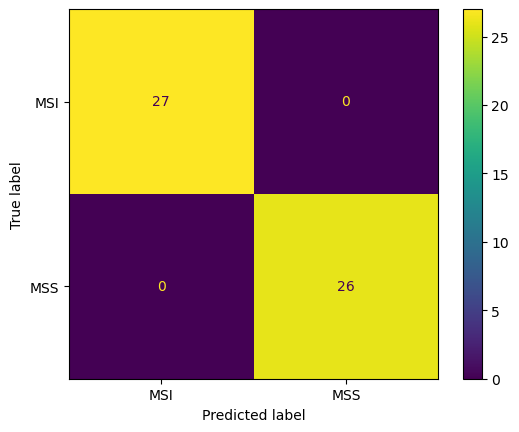

              precision    recall  f1-score   support

         MSI       1.00      1.00      1.00        27
         MSS       1.00      1.00      1.00        26

    accuracy                           1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53



In [33]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [20, 50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MSI', 'MSS'])
plt.figure(figsize=(8, 6)) 
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['MSI', 'MSS'])
print(report)

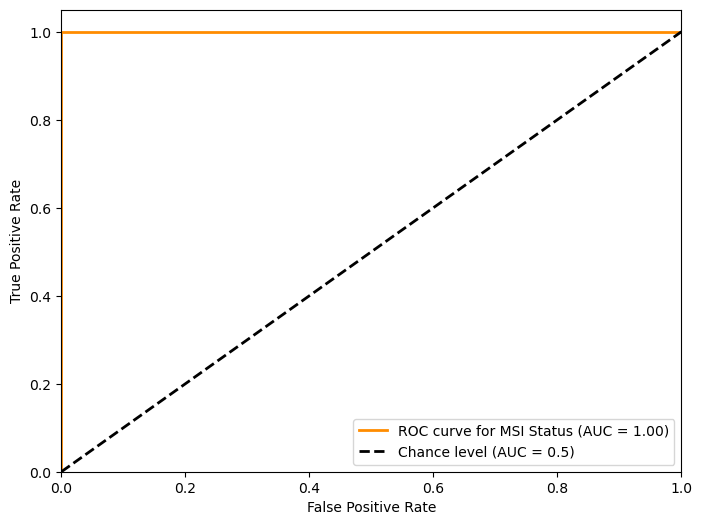

In [34]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for MSI Status (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_3112\951501840.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


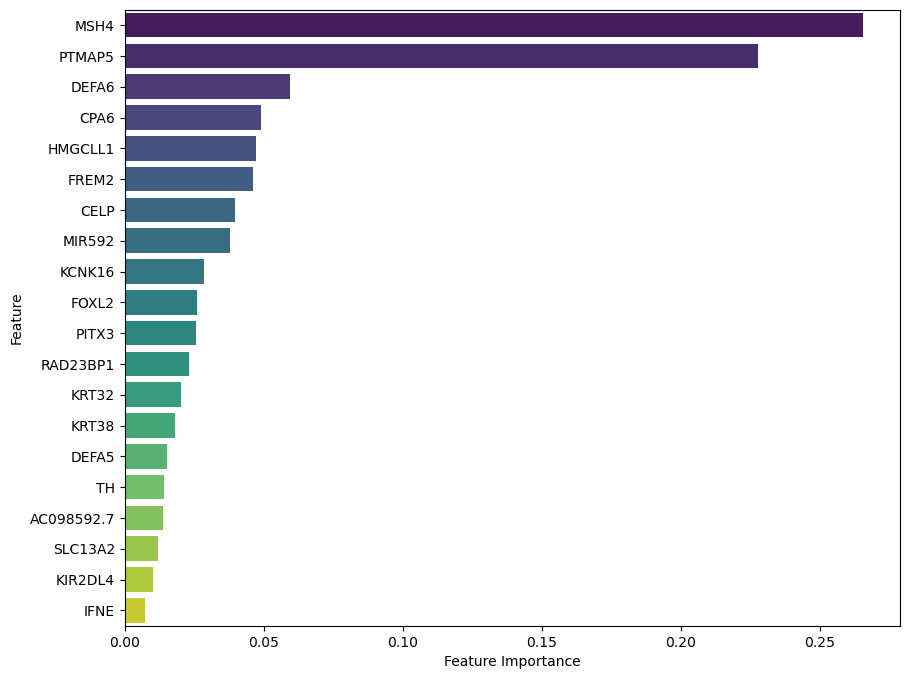

In [35]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

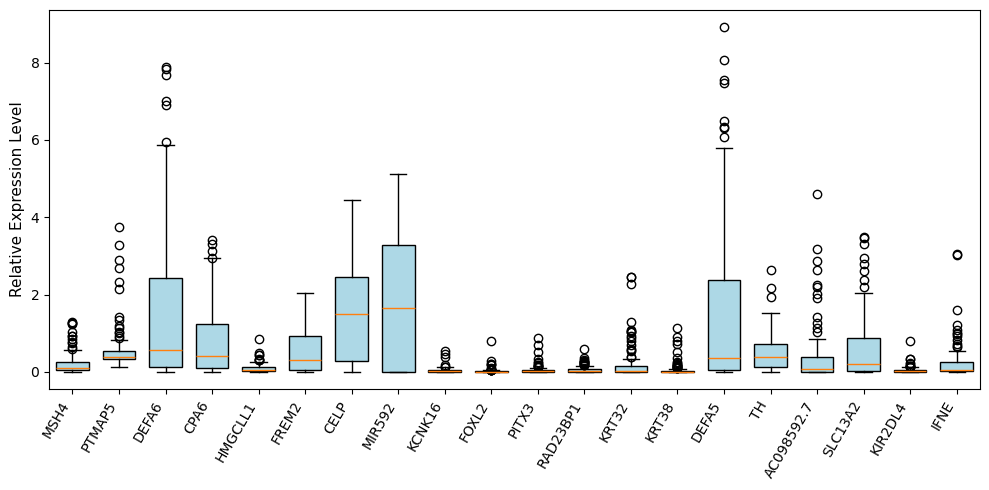

In [36]:
# Box plot for visualizing relative gene expression of 20 most important genes
data = {}
top_20_feature_names = feature_names[top_20_indices]
#abundance_scaled = np.log2(X+1)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

#plt.ylim(-0.5, 8) 
plt.ylabel('Relative Expression Level', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()